## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
tf.config.set_visible_devices([],'GPU')

## Splitting the train and test dataset

In [6]:
train_dataset_path = r'D:\Job_Search_Assignments\Bureau_Assignment\data\train'
validation_dataset_path = r'D:\Job_Search_Assignments\Bureau_Assignment\data\test'

## Data preprocessing

### Initializing image dimensions and batch size 

In [7]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

### Data Augumentation

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary',
                                                   shuffle=True)

Found 4000 images belonging to 2 classes.


In [9]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='binary',
                                                             shuffle=True)

Found 1000 images belonging to 2 classes.


In [10]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : non_resume
1 : resume


## CNN Model Architecture 

In [11]:
def create_model():
     model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=1, activation='sigmoid')  # Binary classification, use 1 output neuron with 'sigmoid' activation
    ])
    
     return model

In [12]:
cnn_model = create_model()

In [13]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 128)     9728      
                                                                 
 activation (Activation)     (None, 220, 220, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      36896     
                                                                 
 activation_1 (Activation)   (None, 108, 108, 32)      0

## Hyperparameters tuning (Early Stopping, Learning Rate)

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [15]:
optimizer = Adam(learning_rate=0.001)

## Model Compilation

In [16]:
cnn_model.compile(optimizer=optimizer, loss= keras.losses.binary_crossentropy, metrics=['accuracy'])

## Model Training

In [17]:
%%time
history = cnn_model.fit(train_generator, epochs= 10, validation_data=validation_generator, verbose=2, callbacks=[reduce_lr])

Epoch 1/10
125/125 - 1258s - loss: 3.3185 - accuracy: 0.7795 - val_loss: 85.4443 - val_accuracy: 0.5120 - lr: 0.0010 - 1258s/epoch - 10s/step
Epoch 2/10
125/125 - 1033s - loss: 3.5316 - accuracy: 0.8023 - val_loss: 47.5129 - val_accuracy: 0.5640 - lr: 0.0010 - 1033s/epoch - 8s/step
Epoch 3/10
125/125 - 560s - loss: 1.6077 - accuracy: 0.8420 - val_loss: 375.7244 - val_accuracy: 0.5000 - lr: 0.0010 - 560s/epoch - 4s/step
Epoch 4/10
125/125 - 657s - loss: 1.0805 - accuracy: 0.8577 - val_loss: 1812.0653 - val_accuracy: 0.5000 - lr: 0.0010 - 657s/epoch - 5s/step
Epoch 5/10
125/125 - 1238s - loss: 0.5686 - accuracy: 0.8645 - val_loss: 1482.2679 - val_accuracy: 0.5000 - lr: 0.0010 - 1238s/epoch - 10s/step
Epoch 6/10
125/125 - 1245s - loss: 0.7579 - accuracy: 0.8597 - val_loss: 531.0414 - val_accuracy: 0.5010 - lr: 0.0010 - 1245s/epoch - 10s/step
Epoch 7/10
125/125 - 1244s - loss: 0.5841 - accuracy: 0.8610 - val_loss: 941.1079 - val_accuracy: 0.5000 - lr: 0.0010 - 1244s/epoch - 10s/step
Epoch 

## Model Evaluation

In [20]:
cnn_model.evaluate(train_generator)

125/125 [==============================] - 400s 3s/step - loss: 0.2707 - accuracy: 0.8903


[0.27068501710891724, 0.890250027179718]

In [21]:
cnn_model.evaluate(validation_generator)

32/32 [==============================] - 88s 3s/step - loss: 2.0673 - accuracy: 0.7360


[2.067267656326294, 0.7360000014305115]

## Model Results

In [24]:
predictions = cnn_model.predict(validation_generator)
predicted_classes = np.round(predictions).flatten()

# Get true labels
true_labels = validation_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
conf_matrix


32/32 [==============================] - 90s 3s/step


array([[108, 392],
       [130, 370]], dtype=int64)

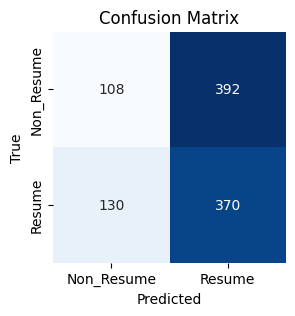

Classification Report:
               precision    recall  f1-score   support

  Non_Resume       0.45      0.22      0.29       500
      Resume       0.49      0.74      0.59       500

    accuracy                           0.48      1000
   macro avg       0.47      0.48      0.44      1000
weighted avg       0.47      0.48      0.44      1000



In [27]:
# Plot confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non_Resume', 'Resume'], yticklabels=['Non_Resume', 'Resume'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
class_report = classification_report(true_labels, predicted_classes, target_names=['Non_Resume', 'Resume'])
print("Classification Report:\n", class_report)